# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 11            
model_seed = 1           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import SVHN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# Optional: you can keep hidden_dims or increase due to higher input size
hidden_dims = [512, 256]  # Suggested for SVHN, but your choice

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics (unchanged)
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.2856 | Test Loss 2.5249 | accs Train 0.1333 Test 0.1377


Epoch 100/2000: Train Loss 0.0000 | Test Loss 11.7230 | accs Train 1.0000 Test 0.1510


Epoch 200/2000: Train Loss 0.0000 | Test Loss 11.7186 | accs Train 1.0000 Test 0.1508


Epoch 300/2000: Train Loss 0.0000 | Test Loss 11.7171 | accs Train 1.0000 Test 0.1508


Epoch 400/2000: Train Loss 0.0000 | Test Loss 11.7242 | accs Train 1.0000 Test 0.1509


Epoch 500/2000: Train Loss 0.0000 | Test Loss 11.7305 | accs Train 1.0000 Test 0.1510


Epoch 600/2000: Train Loss 0.0000 | Test Loss 11.7432 | accs Train 1.0000 Test 0.1511


Epoch 700/2000: Train Loss 0.0000 | Test Loss 11.7581 | accs Train 1.0000 Test 0.1512


Epoch 800/2000: Train Loss 0.0000 | Test Loss 11.7729 | accs Train 1.0000 Test 0.1513


Epoch 900/2000: Train Loss 0.0000 | Test Loss 11.7886 | accs Train 1.0000 Test 0.1513


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 11.8052 | accs Train 1.0000 Test 0.1511


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 11.8214 | accs Train 1.0000 Test 0.1515


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 11.8371 | accs Train 1.0000 Test 0.1519


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 11.8546 | accs Train 1.0000 Test 0.1518


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 11.8712 | accs Train 1.0000 Test 0.1518


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 11.8856 | accs Train 1.0000 Test 0.1521


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 11.8997 | accs Train 1.0000 Test 0.1520


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 11.9151 | accs Train 1.0000 Test 0.1518


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 11.9283 | accs Train 1.0000 Test 0.1517


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 11.9449 | accs Train 1.0000 Test 0.1520


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 11.9634 | accs Train 1.0000 Test 0.1517
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3006 | Test Loss 2.4045 | accs Train 0.1183 Test 0.1689


Epoch 100/2000: Train Loss 0.0026 | Test Loss 3.8482 | accs Train 1.0000 Test 0.4132


Epoch 200/2000: Train Loss 0.0009 | Test Loss 4.2271 | accs Train 1.0000 Test 0.4150


Epoch 300/2000: Train Loss 0.0004 | Test Loss 4.4593 | accs Train 1.0000 Test 0.4159


Epoch 400/2000: Train Loss 0.0003 | Test Loss 4.6304 | accs Train 1.0000 Test 0.4176


Epoch 500/2000: Train Loss 0.0002 | Test Loss 4.7674 | accs Train 1.0000 Test 0.4174


Epoch 600/2000: Train Loss 0.0001 | Test Loss 4.8832 | accs Train 1.0000 Test 0.4176


Epoch 700/2000: Train Loss 0.0001 | Test Loss 4.9785 | accs Train 1.0000 Test 0.4178


Epoch 800/2000: Train Loss 0.0001 | Test Loss 5.0625 | accs Train 1.0000 Test 0.4177


Epoch 900/2000: Train Loss 0.0001 | Test Loss 5.1380 | accs Train 1.0000 Test 0.4177


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.2053 | accs Train 1.0000 Test 0.4182


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 5.2651 | accs Train 1.0000 Test 0.4186


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 5.3202 | accs Train 1.0000 Test 0.4185


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 5.3712 | accs Train 1.0000 Test 0.4187


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 5.4189 | accs Train 1.0000 Test 0.4190


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 5.4657 | accs Train 1.0000 Test 0.4194


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 5.5075 | accs Train 1.0000 Test 0.4195


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.5480 | accs Train 1.0000 Test 0.4196


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.5896 | accs Train 1.0000 Test 0.4193


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.6284 | accs Train 1.0000 Test 0.4193


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.6643 | accs Train 1.0000 Test 0.4195
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3118 | Test Loss 2.3921 | accs Train 0.0950 Test 0.1816


Epoch 100/2000: Train Loss 0.0325 | Test Loss 2.2476 | accs Train 1.0000 Test 0.5805


Epoch 200/2000: Train Loss 0.0040 | Test Loss 2.8568 | accs Train 1.0000 Test 0.5821


Epoch 300/2000: Train Loss 0.0016 | Test Loss 3.1393 | accs Train 1.0000 Test 0.5823


Epoch 400/2000: Train Loss 0.0009 | Test Loss 3.3385 | accs Train 1.0000 Test 0.5812


Epoch 500/2000: Train Loss 0.0006 | Test Loss 3.4915 | accs Train 1.0000 Test 0.5814


Epoch 600/2000: Train Loss 0.0004 | Test Loss 3.6183 | accs Train 1.0000 Test 0.5810


Epoch 700/2000: Train Loss 0.0003 | Test Loss 3.7332 | accs Train 1.0000 Test 0.5813


Epoch 800/2000: Train Loss 0.0002 | Test Loss 3.8309 | accs Train 1.0000 Test 0.5814


Epoch 900/2000: Train Loss 0.0002 | Test Loss 3.9175 | accs Train 1.0000 Test 0.5820


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 3.9983 | accs Train 1.0000 Test 0.5814


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 4.0677 | accs Train 1.0000 Test 0.5816


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 4.1334 | accs Train 1.0000 Test 0.5816


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 4.1930 | accs Train 1.0000 Test 0.5817


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 4.2489 | accs Train 1.0000 Test 0.5811


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 4.3022 | accs Train 1.0000 Test 0.5814


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 4.3511 | accs Train 1.0000 Test 0.5812


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 4.3987 | accs Train 1.0000 Test 0.5812


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 4.4447 | accs Train 1.0000 Test 0.5808


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 4.4897 | accs Train 1.0000 Test 0.5809


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 4.5301 | accs Train 1.0000 Test 0.5811
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3123 | Test Loss 2.3589 | accs Train 0.0932 Test 0.1992


Epoch 100/2000: Train Loss 0.4038 | Test Loss 1.2897 | accs Train 0.8827 Test 0.6570


Epoch 200/2000: Train Loss 0.2108 | Test Loss 1.3157 | accs Train 0.9505 Test 0.6941


Epoch 300/2000: Train Loss 0.0372 | Test Loss 1.6358 | accs Train 0.9997 Test 0.6975


Epoch 400/2000: Train Loss 0.0153 | Test Loss 1.8439 | accs Train 1.0000 Test 0.6969


Epoch 500/2000: Train Loss 0.0082 | Test Loss 1.9962 | accs Train 1.0000 Test 0.6972


Epoch 600/2000: Train Loss 0.0051 | Test Loss 2.1151 | accs Train 1.0000 Test 0.6975


Epoch 700/2000: Train Loss 0.0034 | Test Loss 2.2139 | accs Train 1.0000 Test 0.6972


Epoch 800/2000: Train Loss 0.0025 | Test Loss 2.2982 | accs Train 1.0000 Test 0.6973


Epoch 900/2000: Train Loss 0.0019 | Test Loss 2.3693 | accs Train 1.0000 Test 0.6977


Epoch 1000/2000: Train Loss 0.0015 | Test Loss 2.4327 | accs Train 1.0000 Test 0.6979


Epoch 1100/2000: Train Loss 0.0012 | Test Loss 2.4901 | accs Train 1.0000 Test 0.6983


Epoch 1200/2000: Train Loss 0.0010 | Test Loss 2.5440 | accs Train 1.0000 Test 0.6983


Epoch 1300/2000: Train Loss 0.0008 | Test Loss 2.5917 | accs Train 1.0000 Test 0.6980


Epoch 1400/2000: Train Loss 0.0007 | Test Loss 2.6356 | accs Train 1.0000 Test 0.6981


Epoch 1500/2000: Train Loss 0.0006 | Test Loss 2.6775 | accs Train 1.0000 Test 0.6978


Epoch 1600/2000: Train Loss 0.0005 | Test Loss 2.7152 | accs Train 1.0000 Test 0.6979


Epoch 1700/2000: Train Loss 0.0004 | Test Loss 2.7507 | accs Train 1.0000 Test 0.6981


Epoch 1800/2000: Train Loss 0.0004 | Test Loss 2.7848 | accs Train 1.0000 Test 0.6981


Epoch 1900/2000: Train Loss 0.0003 | Test Loss 2.8165 | accs Train 1.0000 Test 0.6978


Epoch 2000/2000: Train Loss 0.0003 | Test Loss 2.8471 | accs Train 1.0000 Test 0.6979
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3130 | Test Loss 2.3822 | accs Train 0.0967 Test 0.1970


Epoch 100/2000: Train Loss 0.6922 | Test Loss 1.0897 | accs Train 0.7864 Test 0.6871


Epoch 200/2000: Train Loss 0.3595 | Test Loss 0.8565 | accs Train 0.8982 Test 0.7738


Epoch 300/2000: Train Loss 0.1921 | Test Loss 0.8933 | accs Train 0.9566 Test 0.7876


Epoch 400/2000: Train Loss 0.2394 | Test Loss 0.8922 | accs Train 0.9372 Test 0.7812


Epoch 500/2000: Train Loss 0.2121 | Test Loss 1.2075 | accs Train 0.9351 Test 0.7517


Epoch 600/2000: Train Loss 0.0570 | Test Loss 1.1297 | accs Train 0.9953 Test 0.7855


Epoch 700/2000: Train Loss 0.0302 | Test Loss 1.2590 | accs Train 0.9990 Test 0.7842


Epoch 800/2000: Train Loss 0.0176 | Test Loss 1.3753 | accs Train 0.9998 Test 0.7830


Epoch 900/2000: Train Loss 0.0112 | Test Loss 1.4753 | accs Train 0.9999 Test 0.7823


Epoch 1000/2000: Train Loss 0.0076 | Test Loss 1.5582 | accs Train 0.9999 Test 0.7822


Epoch 1100/2000: Train Loss 0.0055 | Test Loss 1.6295 | accs Train 0.9999 Test 0.7818


Epoch 1200/2000: Train Loss 0.0042 | Test Loss 1.6925 | accs Train 0.9999 Test 0.7812


Epoch 1300/2000: Train Loss 0.0033 | Test Loss 1.7479 | accs Train 1.0000 Test 0.7816


Epoch 1400/2000: Train Loss 0.0027 | Test Loss 1.7972 | accs Train 1.0000 Test 0.7814


Epoch 1500/2000: Train Loss 0.0022 | Test Loss 1.8421 | accs Train 1.0000 Test 0.7812


Epoch 1600/2000: Train Loss 0.0019 | Test Loss 1.8825 | accs Train 1.0000 Test 0.7815


Epoch 1700/2000: Train Loss 0.0016 | Test Loss 1.9213 | accs Train 1.0000 Test 0.7815


Epoch 1800/2000: Train Loss 0.0014 | Test Loss 1.9569 | accs Train 1.0000 Test 0.7816


Epoch 1900/2000: Train Loss 0.0012 | Test Loss 1.9910 | accs Train 1.0000 Test 0.7808


Epoch 2000/2000: Train Loss 0.0010 | Test Loss 2.0229 | accs Train 1.0000 Test 0.7807
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3136 | Test Loss 2.3865 | accs Train 0.0964 Test 0.1966


Epoch 100/2000: Train Loss 0.7018 | Test Loss 0.8712 | accs Train 0.7912 Test 0.7451


Epoch 200/2000: Train Loss 0.4646 | Test Loss 0.6947 | accs Train 0.8680 Test 0.8113


Epoch 300/2000: Train Loss 0.3510 | Test Loss 0.6563 | accs Train 0.9026 Test 0.8271


Epoch 400/2000: Train Loss 0.6939 | Test Loss 0.8839 | accs Train 0.7917 Test 0.7447


Epoch 500/2000: Train Loss 0.3465 | Test Loss 0.6702 | accs Train 0.9034 Test 0.8242


Epoch 600/2000: Train Loss 0.4656 | Test Loss 0.7585 | accs Train 0.8608 Test 0.8007


Epoch 700/2000: Train Loss 0.2757 | Test Loss 0.6852 | accs Train 0.9232 Test 0.8297


Epoch 800/2000: Train Loss 0.2156 | Test Loss 0.6950 | accs Train 0.9438 Test 0.8352


Epoch 900/2000: Train Loss 0.2576 | Test Loss 0.6763 | accs Train 0.9287 Test 0.8349


Epoch 1000/2000: Train Loss 0.1986 | Test Loss 0.7015 | accs Train 0.9485 Test 0.8389


Epoch 1100/2000: Train Loss 0.1562 | Test Loss 0.7421 | accs Train 0.9628 Test 0.8385


Epoch 1200/2000: Train Loss 0.2438 | Test Loss 0.7334 | accs Train 0.9294 Test 0.8278


Epoch 1300/2000: Train Loss 0.1646 | Test Loss 0.7512 | accs Train 0.9581 Test 0.8351


Epoch 1400/2000: Train Loss 0.1300 | Test Loss 0.7857 | accs Train 0.9697 Test 0.8358


Epoch 1500/2000: Train Loss 0.1011 | Test Loss 0.8299 | accs Train 0.9785 Test 0.8349


Epoch 1600/2000: Train Loss 0.7512 | Test Loss 0.9876 | accs Train 0.7598 Test 0.7045


Epoch 1700/2000: Train Loss 0.3190 | Test Loss 0.7177 | accs Train 0.9045 Test 0.8175


Epoch 1800/2000: Train Loss 0.2918 | Test Loss 0.7135 | accs Train 0.9148 Test 0.8248


Epoch 1900/2000: Train Loss 0.2063 | Test Loss 0.7404 | accs Train 0.9445 Test 0.8314


Epoch 2000/2000: Train Loss 0.1627 | Test Loss 0.7846 | accs Train 0.9595 Test 0.8326
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 11.9634 | accs: 0.1517
 540 samples | Test Loss: 5.6643 | accs: 0.4195
1940 samples | Test Loss: 4.5301 | accs: 0.5811
5940 samples | Test Loss: 2.8471 | accs: 0.6979
19940 samples | Test Loss: 2.0229 | accs: 0.7807
59940 samples | Test Loss: 0.7846 | accs: 0.8326

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0003 | accs: 1.0000
 Model 19940 | Train Loss: 0.0005 | accs: 1.0000
 Model 59940 | Train Loss: 0.1228 | accs: 0.9667

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 10.1410 | accs: 0.2400
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0003 | accs: 1.0000
 Model 19940 | Train Loss: 0.0016 | accs: 1.0000
 Model 59940 | Tr

 Model    0 | Train Loss: 10.4186 | accs: 0.1547
 Model  540 | Train Loss: 4.9782 | accs: 0.4384
 Model 1940 | Train Loss: 3.5795 | accs: 0.6221
 Model 5940 | Train Loss: 2.0747 | accs: 0.7495
 Model 19940 | Train Loss: 1.0457 | accs: 0.8696
 Model 59940 | Train Loss: 0.1665 | accs: 0.9575


### Model + Data Specific Verification

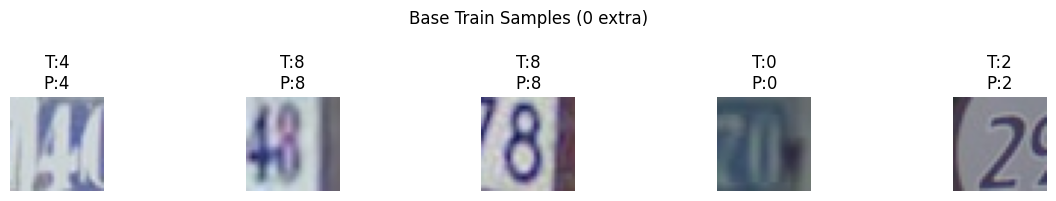

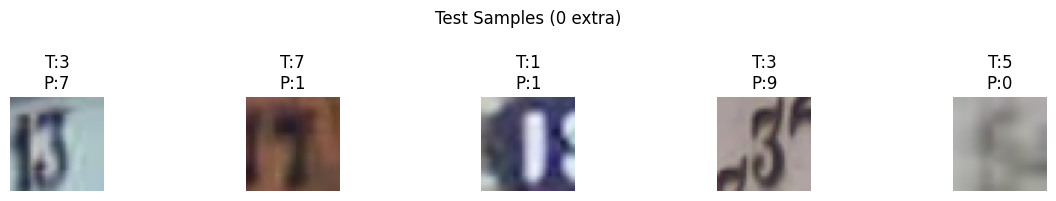

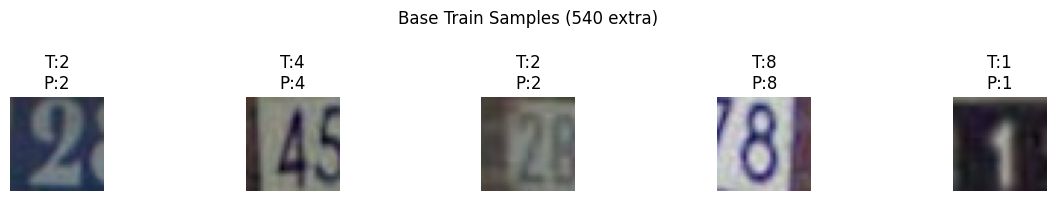

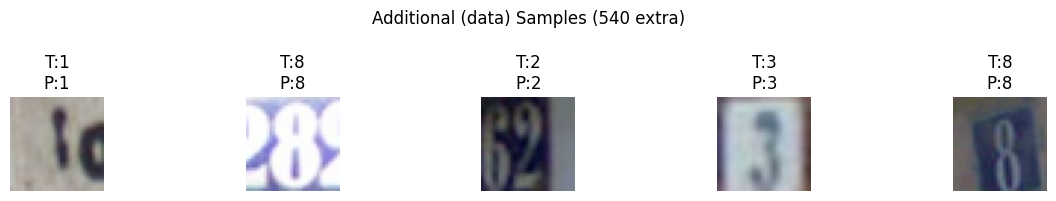

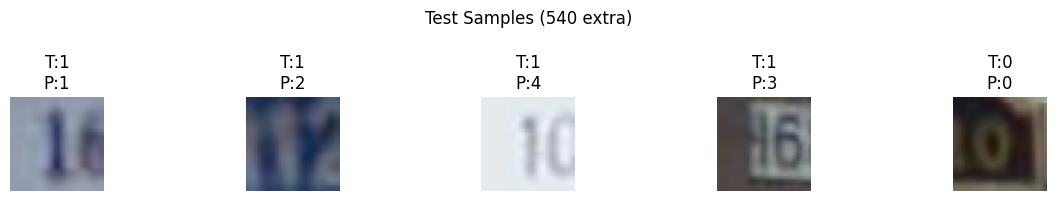

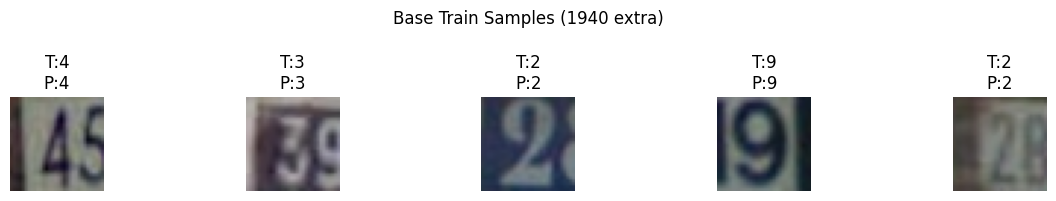

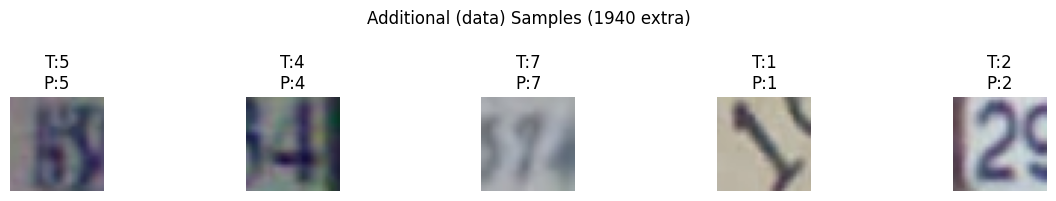

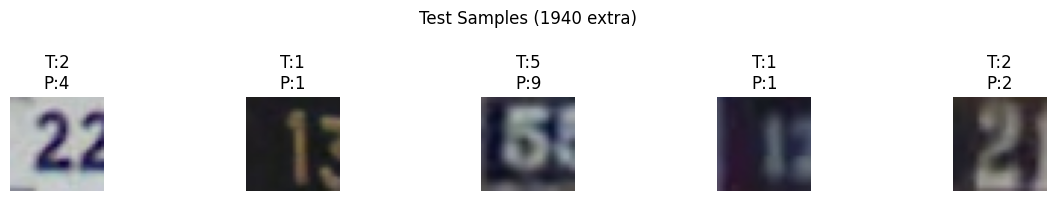

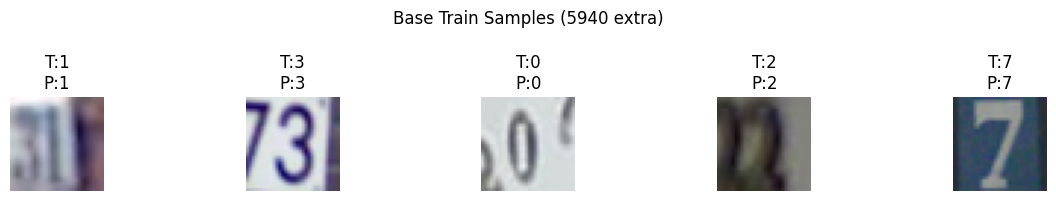

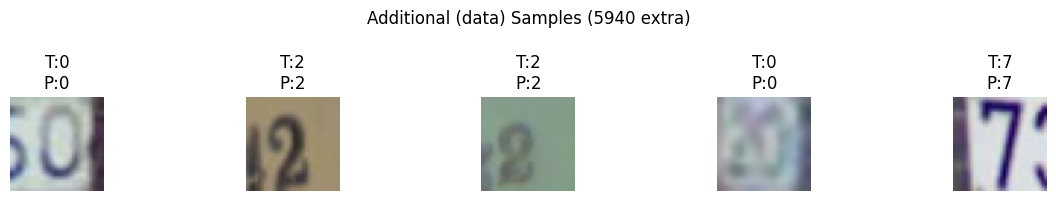

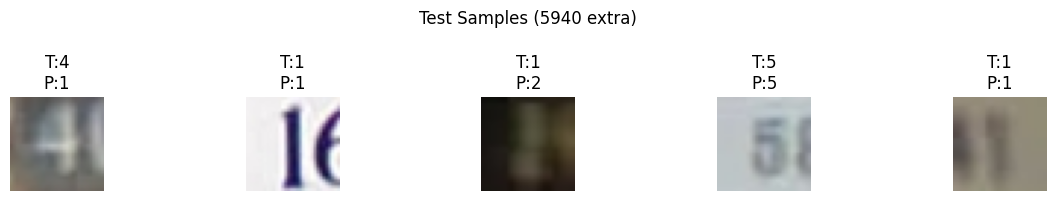

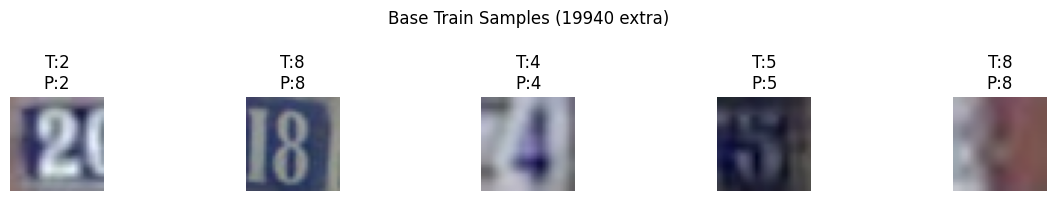

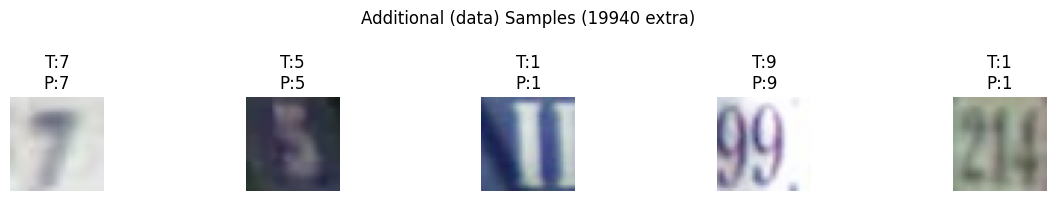

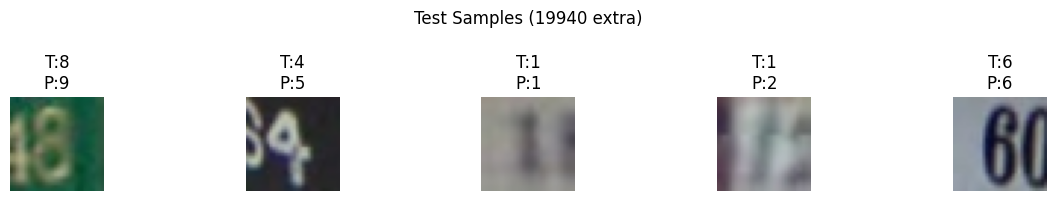

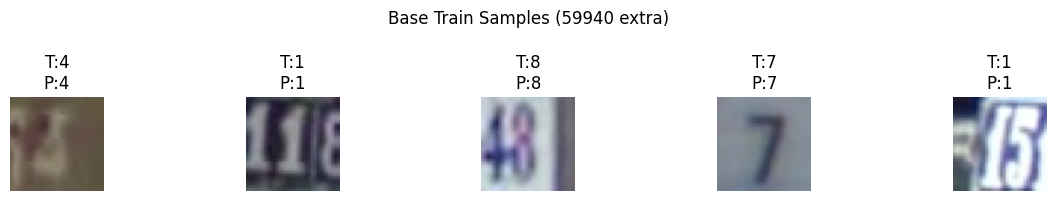

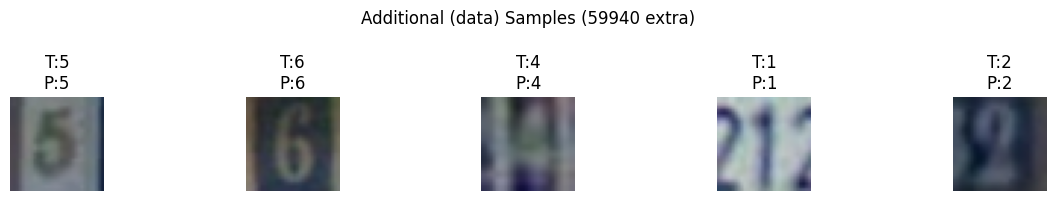

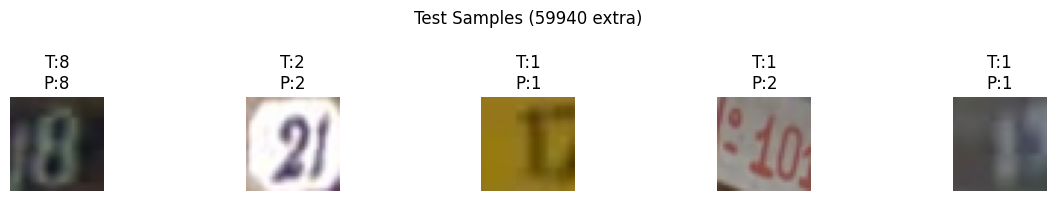

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
